In [1]:
import urllib, string, os, math, cmath, re, nltk, gensim, time, sklearn, matplotlib, pickle
import numpy as np
import pandas as pd
import _pickle as cPickle
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
from nltk.corpus import stopwords
from gensim.models import LdaModel
from gensim import models, corpora, similarities
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk import FreqDist
from scipy.stats import entropy

## Get the Data from ArXiv

In [2]:
data_dfKeys = ['id','authors','published','title','abstitle',"prim_cat"]
data_df = pd.DataFrame(columns=data_dfKeys)

tmp_dict = {}
for year in range(1993,2020):
    filename = "../Arxiv_DataSet/ArXivCS_"+str(year)+".pickle"
    tmp_df = pd.read_pickle(filename)
    tmp_dict[year] = len(tmp_df)
    #print year, len(tmp_df)
    data_df = data_df.append(tmp_df, ignore_index=True)
#del tmp_dict[2017]

# Dropping duplicates!
print("duplicated entries = ", data_df['id'].duplicated().sum())
data_df = data_df.drop_duplicates(subset="id")
data_df = data_df.reset_index(drop=True)
print("duplicated entries after removal = ", data_df['id'].duplicated().sum())

duplicated entries =  24396
duplicated entries after removal =  0


27 27


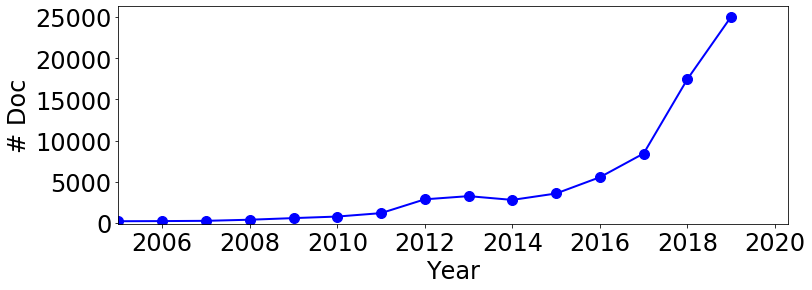

In [3]:
lists = sorted(tmp_dict.items()); # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
x = np.asarray(x).reshape(-1,1);
y = np.asarray(y).reshape(-1,1);
#regr = sklearn.linear_model.LinearRegression()
print (len(x), len(y));
#model = regr.fit(x,y)
plt.figure(figsize=(12,4))
plt.plot(x, y, "-o", lw=2,ms=10, color='blue');
#plt.plot(x, regr.predict(x), color='blue',linewidth=3)
plt.xlabel("Year",size=24);
plt.ylabel("# Doc",size=24);
plt.xticks(size=24);
plt.yticks(size=24);
plt.ylim(ymin=-100);
plt.xlim(left=2005);
#print('Coefficients: ', regr.coef_[0])
#print("Intercept: ", regr.intercept_)

In [4]:
print("total number of documents: ", len(data_df))
data_df.sort_values(by="id").head()

total number of documents:  49207


,id,authors,published,title,abstitle,prim_cat
1333,0704.0047,"T. Kosel, I. Grabec",unpublished,intelligent location of simultaneously active ...,intelligent location simultaneously active aco...,cs.NE
1334,0704.0050,"T. Kosel, I. Grabec",unpublished,intelligent location of simultaneously active ...,intelligent location simultaneously active aco...,cs.NE
1343,0704.0304,Carlos Gershenson,"Minai, A., Braha, D., and Bar-Yam, Y., eds. Un...",the world as evolving information,world evolving information paper discusses ben...,cs.IT
1324,0704.0671,Maxim Raginsky,DOI:10.1109/ITW.2007.4313111,learning from compressed observations,learning compressed observations problem stati...,cs.IT
1325,0704.0954,"Soummya Kar, Jose M. F. Moura",DOI:10.1109/TSP.2008.920143,sensor networks with random links topology des...,sensor networks random links topology design d...,cs.IT


In [5]:
def fix_cat(in_cat): 
    if(in_cat=="cond-mat.stat-mech"):
        return "stat-mech"
    if(in_cat=="cond-mat.supr-con"):
        return "supr-con"
    if(in_cat=="cond-mat.dis-nn"):
        return "dis-nn"
    if(in_cat=="cond-mat.mes-hall"):
        return "mes-hall"
    if(in_cat=="cond-mat.str-el"):
        return "str-el"
    if(in_cat=="cond-mat.mtrl-sci"):
        return "mtrl-sci"
    if(in_cat=="cond-mat.soft"):
        return "soft"
    if(in_cat=="cond-mat.quant-gas"):
        return "quant-gas"
    if(in_cat=="cond-mat.other"):
        return "other"
    if(in_cat=="cond-mat"):
        return "other"
    return in_cat; 
    
data_df["prim_cat"] = data_df["prim_cat"].apply(fix_cat); 

In [6]:
def length_of(input_val): 
    return len(input_val);

data_df["word_count"] = data_df["abstitle"].apply(length_of);
data_df["title_count"] = data_df["title"].apply(length_of);

In [7]:
nltk.download('punkt')
nltk.download('wordnet')
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = text.replace("model ","");
    text = text.replace("predict ","");
    text = text.replace("algorithm ","");
    text = text.replace("learn ","");
    
    #text = text.split(",")
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

lemmatizer = WordNetLemmatizer() 
stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem/lemmatize words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [lemmatizer.lemmatize(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    #text = text.encode("utf8")
    #intext = ", ".join([x for x in text])
    #print(intext); 
    
    words = stem_words(remove_stop_words(initial_clean(text)))
    outtext = " ".join([x for x in words])
    return outtext

[nltk_data] Downloading package punkt to /home/npatel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/npatel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
## -- with steming the words --
#data_df["cleaned_abstitle"] = data_df["abstitle"].apply(apply_all)
#data_df.to_csv("cleaned_data.csv")
data_df = pd.read_csv("cleaned_data.csv")

## -- with lemmatization --
#data_df["cleaned_abstitle"] = data_df["abstitle"].apply(apply_all)
#data_df.to_csv("cleaned_data_lemmatization.csv")
#data_df = pd.read_csv("cleaned_data_lemmatization.csv")

In [9]:
print(data_df.iloc[1]["abstitle"], " \n")
print(data_df.iloc[1]["cleaned_abstitle"])

marketoriented programming environment application distributed multicommodity flow problems market price systems constitute wellunderstood class mechanisms certain conditions provide effective decentralization decision making minimal communication overhead marketoriented programming approach distributed problem solving derive activities resource allocations set computational agents computing competitive equilibrium artificial economy walras provides basic constructs defining computational market structures protocols deriving corresponding price equilibria particular realization approach form multicommodity flow problem see careful construction decision process according economic principles lead efficient distributed resource allocation behavior system meaningfully analyzed economic terms  

marketori program environ applic distribut multicommod flow problem market price system constitut wellunderstood class mechan certain condit provid effect decentr decis make minim commun overhead ma

In [10]:
print("Number of categories on ArXiv: ", len(data_df["prim_cat"].unique()))
print("Categories on ArXiv: ", data_df["prim_cat"].unique())

Number of categories on ArXiv:  40
Categories on ArXiv:  ['cs.AI' 'cs.CC' 'cs.NE' 'cs.LG' 'cs.CL' 'cs.LO' 'cs.MA' 'cs.IR' 'cs.CG'
 'cs.RO' 'cs.DB' 'cs.DL' 'cs.SE' 'cs.DS' 'cs.CV' 'cs.PL' 'cs.DC' 'cs.CE'
 'cs.PF' 'cs.DM' 'cs.NI' 'cs.GT' 'cs.HC' 'cs.CR' 'cs.SD' 'cs.OH' 'cs.CY'
 'cs.MM' 'cs.IT' 'cs.MS' 'cs.AR' 'cs.NA' 'cs.GR' 'cs.SC' 'cs.SY' 'cs.SI'
 'cs.FL' 'cs.ET' 'cs.GL' 'cs.OS']


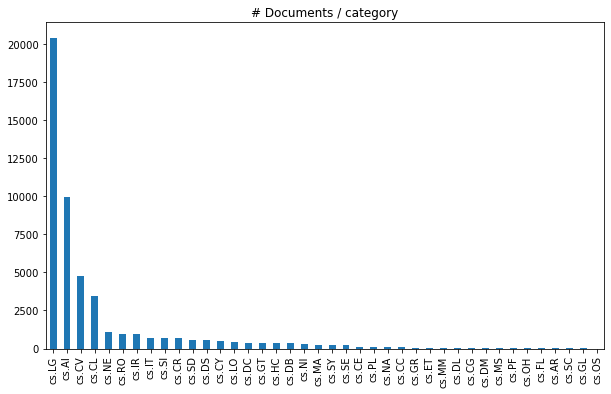

In [11]:
plt.figure(figsize=(10,6))
cat_count = pd.Series.value_counts(data_df['prim_cat'])
cat_count.plot.bar(title="# Documents / category")

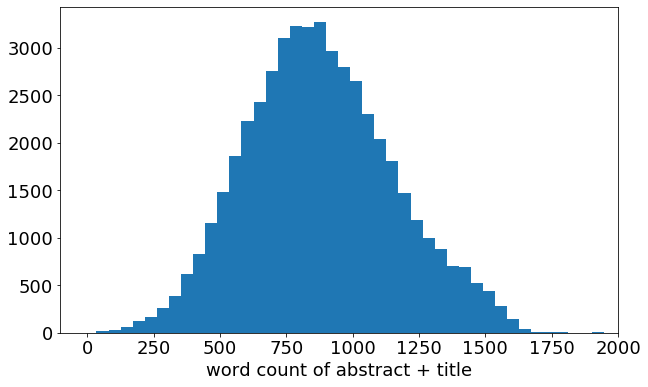

In [12]:
plt.figure(figsize=(10,6))
plt.hist(data_df["word_count"],bins=60);
#plt.hist(data_df["title_count"],bins=60);
plt.xlim(right=2000);
plt.xlabel("word count of abstract + title",size=18);
plt.xticks(size=18); 
plt.yticks(size=18); 

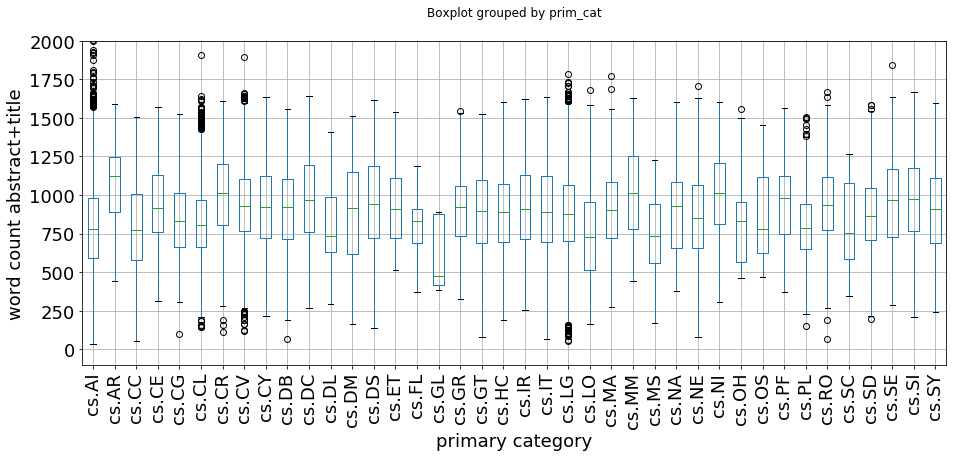

In [13]:
data_df.boxplot(column=['word_count'], by=['prim_cat'],figsize=(15,6));
plt.xticks(rotation=90);
plt.ylim(top=2000);
plt.xticks(size=18); 
plt.yticks(size=18); 
plt.xlabel("primary category",size=18); 
plt.ylabel("word count abstract+title",size=18);
plt.title(" ");


In [14]:
len(data_df)

49207

<h2> Preparing Data for LDA </h2>

In [18]:
text_data = []
for line in data_df["cleaned_abstitle"]:
    tokens = line.split(" ");
    text_data.append(tokens)

In [19]:
# creating dictionary of all unique words, and copus - bag of word for each document
from gensim import corpora
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

# tf vectorize
dictionary = corpora.Dictionary(text_data)
tf_corpus = [dictionary.doc2bow(text) for text in text_data]

# tfidf - vectorize 
tfidf_model = TfidfModel(tf_corpus)  # fit model
tfidf_corpus = tfidf_model[tf_corpus]      # apply model to the first corpus document

In [20]:
print(data_df.iloc[1]["cleaned_abstitle"])
for i in range(0,len(tf_corpus[1])): 
    word_index = tf_corpus[1][i][0]
    print(tf_corpus[1][i], tfidf_corpus[1][i], dictionary[word_index])

marketori program environ applic distribut multicommod flow problem market price system constitut wellunderstood class mechan certain condit provid effect decentr decis make minim commun overhead marketori program approach distribut problem solv deriv activ resourc alloc set comput agent comput competit equilibrium artifici economi walra provid basic construct defin comput market structur protocol deriv correspond price equilibrium particular realiz approach form multicommod flow problem see care construct decis process accord econom principl lead effici distribut resourc alloc behavior system meaning analyz econom term
(0, 2) (0, 0.04510719203517905) approach
(15, 1) (15, 0.09017882916903075) meaning
(24, 3) (24, 0.06466384000998082) problem
(26, 2) (26, 0.062043402225808834) provid
(31, 1) (31, 0.04818399509917718) solv
(41, 1) (41, 0.07875281625448342) accord
(42, 1) (42, 0.06033586659880772) activ
(43, 1) (43, 0.05788679518237641) agent
(44, 2) (44, 0.19066585921268325) alloc
(45, 

In [21]:
# printing corpus and dictionary to a file
pickle.dump(tf_corpus, open('corpus.pkl', 'wb'))
pickle.dump(tfidf_corpus,open("tfidf_corpus.pkl","wb"))
pickle.dump(tfidf_model,open("tfidfmodel.pkl","wb"))

#dictionary.save('dictionary.gensim')
pickle.dump(dictionary,open("dictionary.pkl","wb"))

In [22]:
tf_corpus = pickle.load(open("corpus.pkl","rb"))
tfidf_corpus = pickle.load(open("tfidf_corpus.pkl","rb"))
tfidf_model = pickle.load(open("tfidfmodel.pkl","rb"))
dictionary = pickle.load(open("dictionary.pkl","rb"))

In [23]:
print(dictionary)

Dictionary(80397 unique tokens: ['approach', 'avoid', 'backtrack', 'complet', 'control']...)


# Finding the correct number of topics

<span>
    Separate calculations of coherence score using 1000 subset of documents show that coherence score is maximum for approximate topic of 10. Therefore, we shall use 10 topics as the optimal number topics for interpratibility of the topic distribution of each document. 
</span>

<h1> LDA modeling </h1>

Documentation: 
https://radimrehurek.com/gensim/models/ldamodel.html <br>
class gensim.models.ldamodel.LdaModel(corpus=None, num_topics=100, id2word=None, 
                                      distributed=False, chunksize=2000, passes=1, 
                                      update_every=1, alpha='symmetric', eta=None, 
                                      decay=0.5, offset=1.0, eval_every=10, iterations=50, 
                                      gamma_threshold=0.001, minimum_probability=0.01, 
                                      random_state=None, ns_conf=None, minimum_phi_value=0.01, 
                                      per_word_topics=False, callbacks=None, 
                                      dtype=<class 'numpy.float32'>)


In [25]:
import gensim

# number of expected topics
NUM_TOPICS = 10

# training model 
t0 = time()
ldamodel = gensim.models.ldamulticore.LdaMulticore(
    tfidf_corpus, num_topics = NUM_TOPICS, chunksize=10000, 
    id2word=dictionary, iterations=1000, passes=40, 
    workers=4) 
print("done in %0.3fs." % (time() - t0))

done in 1156.243s.


In [26]:
# save the model d
ldamodel.save('tfidf_model10.gensim')

In [27]:
# save the model d
ldamodel = LdaModel.load('tfidf_model10.gensim')

topics = ldamodel.print_topics(num_words=6)
for topic in topics:
    print(topic)

(0, '0.001*"traffick" + 0.001*"maxent" + 0.001*"suicid" + 0.000*"angri" + 0.000*"esport" + 0.000*"veget"')
(1, '0.001*"outfit" + 0.001*"poem" + 0.001*"poetri" + 0.001*"timet" + 0.001*"uap" + 0.001*"vin"')
(2, '0.004*"network" + 0.004*"graph" + 0.003*"optim" + 0.003*"function" + 0.003*"method" + 0.003*"learn"')
(3, '0.012*"polici" + 0.009*"reward" + 0.007*"reinforc" + 0.007*"bandit" + 0.005*"regret" + 0.005*"rl"')
(4, '0.002*"keyphras" + 0.001*"warmup" + 0.001*"sonar" + 0.000*"ndf" + 0.000*"dialect" + 0.000*"plda"')
(5, '0.002*"na" + 0.001*"fl" + 0.001*"communicationeffici" + 0.001*"ldp" + 0.001*"gossip" + 0.001*"fedavg"')
(6, '0.004*"imag" + 0.003*"adversari" + 0.003*"model" + 0.003*"task" + 0.003*"languag" + 0.003*"train"')
(7, '0.001*"mooc" + 0.001*"kw" + 0.001*"listwis" + 0.001*"flock" + 0.000*"mmc" + 0.000*"subnet"')
(8, '0.001*"confer" + 0.001*"proceed" + 0.000*"steganalysi" + 0.000*"tnn" + 0.000*"sac" + 0.000*"multifidel"')
(9, '0.004*"agent" + 0.004*"robot" + 0.004*"system" + 0.

In [35]:
#https://stackoverflow.com/questions/19504898/use-scikit-learn-tfidf-with-gensim-lda
#https://stackoverflow.com/questions/21552518/using-scikit-learn-vectorizers-and-vocabularies-with-gensim
#lda = gensim.models.ldamodel.LdaModel(corpus=tfidf, id2word=id2word, num_topics=100, update_every=1, passes=1)

## model evaluation
# https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/topic_coherence_tutorial.ipynb

# Finding the correct number of topics

In [39]:
cutsize=1000
cutdata_df = data_df.sample(n=cutsize)
text_data = []
for line in cutdata_df["cleaned_abstitle"]:
    tokens = line.split(" ");
    text_data.append(tokens)

# creating dictionary of all unique words, and copus - bag of word for each document
from gensim import corpora
cut_dictionary = corpora.Dictionary(text_data)
cut_corpus = [dictionary.doc2bow(text) for text in text_data]

In [70]:
# LDA model with gibbs sampling
out = []
for num_topics in range(2,50,2): 
    
    # training model 
    ldamodel = gensim.models.ldamulticore.LdaMulticore(
        cut_corpus, num_topics = num_topics, chunksize=cutsize, 
        id2word=dictionary, iterations=1000, passes=40, 
        workers=4);

    perplexity = ldamodel.log_perplexity(cut_corpus)
    print(num_topics,perplexity)
    out.append([num_topics,perplexity]);

2 -8.036908954077802
4 -8.01535995802318
6 -7.884395625329391
8 -7.804085350195517
10 -7.848754734890653
12 -7.780371237401774
14 -7.793405657529297
16 -7.8522775750534075
18 -7.8026460118314915
20 -7.777303494983238
22 -7.747758726830106
24 -7.814021142125278
26 -7.8034478237572555
28 -7.764704966640374
30 -7.7004610198952435
32 -7.755723834079475
34 -7.848463209125364
36 -7.863581608961403
38 -7.84408934136948
40 -7.817520433330082
42 -7.759415730110067
44 -7.865731751477404
46 -7.8654898446872235
48 -7.797942234460061


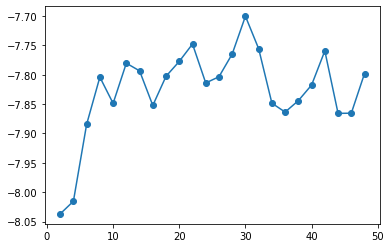

In [74]:
out1000 = np.asarray(out)
#plt.plot(out100[:,0],out100[:,1],"o-")
plt.plot(out1000[:,0],out1000[:,1],"o-")

In [75]:
for i in range(len(out100)):
    print(out100[i,0],out100[i,1],out1000[i,1]);

2.0 -9.311076716183683 -8.036908954077802
4.0 -9.391854136873011 -8.01535995802318
6.0 -9.090104465471317 -7.884395625329391
8.0 -9.12625694768496 -7.804085350195517
10.0 -8.952424275992946 -7.848754734890653
12.0 -8.996909146978226 -7.780371237401774
14.0 -8.954099763146862 -7.793405657529297
16.0 -9.111896277518364 -7.8522775750534075
18.0 -8.93384057355165 -7.8026460118314915
20.0 -8.952660110311623 -7.777303494983238
22.0 -8.863691498985633 -7.747758726830106
24.0 -9.108388144543326 -7.814021142125278
26.0 -9.107662955239217 -7.8034478237572555
28.0 -9.566421909743486 -7.764704966640374
30.0 -8.769101842671937 -7.7004610198952435
32.0 -9.224072042242941 -7.755723834079475
34.0 -8.944106487803797 -7.848463209125364
36.0 -8.750992349656 -7.863581608961403
38.0 -9.045241281769428 -7.84408934136948
40.0 -8.798865255198866 -7.817520433330082
42.0 -8.934705873252641 -7.759415730110067
44.0 -8.99343749940302 -7.865731751477404
46.0 -8.96274406819392 -7.8654898446872235
48.0 -9.00508037928

In [71]:
print(out100)

[[ 2.         -9.31107672]
 [ 4.         -9.39185414]
 [ 6.         -9.09010447]
 [ 8.         -9.12625695]
 [10.         -8.95242428]
 [12.         -8.99690915]
 [14.         -8.95409976]
 [16.         -9.11189628]
 [18.         -8.93384057]
 [20.         -8.95266011]
 [22.         -8.8636915 ]
 [24.         -9.10838814]
 [26.         -9.10766296]
 [28.         -9.56642191]
 [30.         -8.76910184]
 [32.         -9.22407204]
 [34.         -8.94410649]
 [36.         -8.75099235]
 [38.         -9.04524128]
 [40.         -8.79886526]
 [42.         -8.93470587]
 [44.         -8.9934375 ]
 [46.         -8.96274407]
 [48.         -9.00508038]]


In [41]:
data_df = pd.read_csv("cleaned_data.csv")

In [42]:
def clean_text_model(x):
    x = x.replace("model ","");
    x = x.replace("predict ","");
    x = x.replace("algorithm ","");
    x = x.replace("learn ","");
    return x; 
    
data_df["cleaned_abstitle"] = data_df["cleaned_abstitle"].apply(clean_text_model)

In [108]:
text_data = []
for line in data_df["cleaned_abstitle"]:
    tokens = line.split(" ");
    #    if np.random.random() > .999:
    #        print(tokens)
    text_data.append(tokens)

# creating dictionary of all unique words, and copus - bag of word for each document
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

# printing corpus and dictionary to a file
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
#dictionary.save('dictionary.gensim')
pickle.dump(dictionary,open("dictionary.pkl","wb"))

In [109]:
import gensim

# number of expected topics
NUM_TOPICS = 14

# training model 
t0 = time()
ldamodel = gensim.models.ldamulticore.LdaMulticore(
    corpus, num_topics = NUM_TOPICS, chunksize=10000, 
    id2word=dictionary, iterations=1000, passes=100, 
    workers=4) 
print("done in %0.3fs." % (time() - t0))

# save the model d
ldamodel.save('model14.gensim')
#topics = ldamodel.print_topics(num_words=6)
#for topic in topics:
#    print(topic)

done in 1852.132s.


In [110]:
# save the model d
ldamodel = LdaModel.load('model14.gensim')

topics = ldamodel.print_topics(num_words=6)
for topic in topics:
    print(topic)

(0, '0.017*"data" + 0.016*"method" + 0.014*"estim" + 0.013*"use" + 0.012*"infer" + 0.011*"problem"')
(1, '0.056*"gener" + 0.020*"train" + 0.013*"propos" + 0.013*"imag" + 0.012*"latent" + 0.012*"distribut"')
(2, '0.027*"agent" + 0.020*"reinforc" + 0.017*"environ" + 0.015*"task" + 0.015*"control" + 0.014*"robot"')
(3, '0.012*"system" + 0.011*"program" + 0.010*"logic" + 0.010*"reason" + 0.010*"use" + 0.008*"knowledg"')
(4, '0.088*"network" + 0.048*"neural" + 0.034*"deep" + 0.022*"train" + 0.014*"architectur" + 0.013*"convolut"')
(5, '0.025*"polici" + 0.019*"optim" + 0.017*"problem" + 0.015*"onlin" + 0.014*"function" + 0.014*"decis"')
(6, '0.026*"data" + 0.022*"label" + 0.017*"dataset" + 0.016*"classif" + 0.016*"task" + 0.015*"train"')
(7, '0.019*"data" + 0.016*"system" + 0.015*"user" + 0.014*"use" + 0.011*"machin" + 0.008*"recommend"')
(8, '0.035*"graph" + 0.025*"featur" + 0.021*"cluster" + 0.019*"method" + 0.017*"data" + 0.016*"embed"')
(9, '0.017*"bound" + 0.016*"function" + 0.013*"grad

## Load Saved Model and Model Parameters

In [ ]:
tf = cPickle.load(open('model_parameters/tf.p','rb'),encoding='iso-8859-1')

In [ ]:
tfidf = cPickle.load(open('model_parameters/tfidf.p','rb'),encoding='iso-8859-1')

In [ ]:
tfidf_feature_names = cPickle.load(open('model_parameters/tfidf_feature_names.p','rb'),encoding='iso-8859-1')

In [ ]:
lda = cPickle.load(open('model_parameters/LDAclassifier.model','rb'),encoding='iso-8859-1')

## Get predictions for retrieval tasks

In [ ]:
## Get preditions to find nearest neighbors
pred = [lda.transform(tf[index]) for index in range(0,len(data_df))]
pred = np.array(pred)

In [ ]:
cPickle.dump(pred, open('model_parameters/pred.p', 'wb')) 

In [ ]:
pred = cPickle.load(open('model_parameters/pred.p','rb'),encoding='iso-8859-1')

In [ ]:
print(pred[0])
print(pred[1])
print(pred[2])
print(pred[3])

In [ ]:
def QueryLda(model,data,q,kneighbors,predictions,tfidf):
    from scipy.spatial import distance
    N = len(predictions)
    query = predictions[q]
    dis = np.array([(int(i),distance.euclidean(predictions[i],query)) for i in range(0,N)])
    dis = dis[dis[:,1].argsort()]
    #print(dis[0:kneighbors])
    return [int(dis[x,0]) for x in range(0,kneighbors)]

In [ ]:
def printneighbors(nb,model,data,tfidf,predictions):
    for n in nb:
        print (n)
        print (data.loc[n])
        print (data_df['abstitle'][n])
        print (predictions[n])
    print ( " ")

In [ ]:
def tfidfToWords(doc, tf_idf, feature_names,highestn):
    feature_index = tf_idf[doc,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [tf_idf[doc, x] for x in feature_index])
    out = []
    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
        tmp = [w, s]
        out.append(tmp)
    out = np.array(out)
    perm = np.argsort(out[:,1])
    out = out[perm][::-1]
#     for k in range(0,highestn):
#         print out[k]
    return out[:highestn]

In [ ]:
def plotbar(x,doc,outfile):
    import matplotlib.pyplot as plt
    %matplotlib inline
    category = x[:,0]
    category_counts = x[:,1]
    indexes = np.arange(len(category))
    width=0.7
    plt.figure(figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
    titlelabel = "term frequency (tf) of document: " + str(doc)
    plt.title(titlelabel,fontsize=25, color='black')
    plt.bar(indexes,category_counts,width)
    plt.xticks(indexes+width*0.5,category,rotation='vertical',fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.savefig(outfile)
    plt.show()

#### Document: 365

In [ ]:
id = 356
neigh = QueryLda(lda,data_df,id,6,pred,tfidf)
printneighbors(neigh,lda,data_df,tfidf,pred)

In [ ]:
#wordcount = np.array(tfidfToWords(id,tf,tfidf_feature_names,20))
#plotbar(wordcount,id,"query1.pdf")

### Document 21281

In [ ]:
id = 21281
neigh = QueryLda(lda,data_df,id,6,pred,tfidf)
printneighbors(neigh,lda,data_df,tfidf,pred)

In [ ]:
#wordcount = np.array(tfidfToWords(21281,tf,tfidf_feature_names,20))
#plotbar(wordcount,21281,"query2.pdf")

### Document 32461

In [ ]:
#neigh = QueryLda(lda,data_df,32461,10,pred,tf)
#printneighbors(neigh,lda,data_df,tf)
#tfidfToWords(32461,tf,tfidf_feature_names,20)

In [ ]:
#wordcount = np.array(tfidfToWords(32461,tf,tfidf_feature_names,30))
#plotbar(wordcount,32461,"query3.pdf")

### Document 209992

In [ ]:
data_df[data_df['id']=='1604.03621']

In [ ]:
id = 209992
neigh = QueryLda(lda,data_df,id,6,pred,tfidf)
printneighbors(neigh,lda,data_df,tfidf,pred)

In [ ]:
#wordcount = np.array(tfidfToWords(209992,tf,tfidf_feature_names,30))
#plotbar(wordcount,209992,"query4.pdf")

### Document 168936

In [ ]:
data_df[data_df['id']=='1309.5119']

In [ ]:
id = 168936
neigh = QueryLda(lda,data_df,id,6,pred,tfidf)
printneighbors(neigh,lda,data_df,tfidf,pred)

In [ ]:
#wordcount = np.array(tfidfToWords(168936,tf,tfidf_feature_names,30))
#plotbar(wordcount,168936,"query5.pdf")

# Backup 

In [ ]:
# Vectorize Text Data

<h3> term freq. (tf) vectorizer. </h3> 

print("Building term frequency")
stop_words = stopwords.words('english')
tf_vectorizer = CountVectorizer(stop_words=stop_words,ngram_range=(1, 1))
tf = tf_vectorizer.fit_transform(data_df.iloc[0:10000]['cleaned_abstitle'])
#cPickle.dump(tf, open('model_parameters/tf.p', 'wb'))

#tf_vectorizer.get_feature_names()

<h3> tf-idf vectorizer. </h3> 

print ("Building tfidf sparse matrix")
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True,ngram_range=(1,2),max_features=10)
tfidf = tfidf_vectorizer.fit_transform(data_df['cleaned_abstitle'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#tfidf = normalize(tfidf)

cPickle.dump(tfidf, open('model_parameters/tfidf.p', 'wb')) 
cPickle.dump(tfidf_feature_names, open('model_parameters/tfidf_feature_names.p', 'wb'))

tfidf_feature_names

lda = LatentDirichletAllocation(n_components=25,max_iter=20,
                                batch_size=128,learning_decay=0.7,
                                learning_method='online',learning_offset=10.,
                                mean_change_tol=0.001,random_state=0,
                                verbose=128)

t0 = time()
print("Starting to fit the LDA model @ time = ", t0)
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

